In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

# Path to the ZIP file
zip_path = '/content/drive/MyDrive/Project/BrainTumorDataset.zip'
extract_to = '/content/dataset'

# Extract ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Verify extraction
import os
print(os.listdir(extract_to))


['figshare-brain-tumor-dataset']


In [4]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 114.6 MB/s eta 0:00:00


In [5]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Concatenate
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pennylane as qml
import h5py
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [6]:
# Constants
IMG_WIDTH, IMG_HEIGHT = 128, 128
NUM_CLASSES = 3
BATCH_SIZE = 32
EPOCHS = 100
N_QUBITS = 8

# Utility Functions
def load_mat_file_v7_3(filepath):
    with h5py.File(filepath, 'r') as file:
        label = np.array(file['cjdata']['label']).squeeze()
        image = np.array(file['cjdata']['image']).T
        tumor_mask = np.array(file['cjdata']['tumorMask']).T
        return label, image, tumor_mask

def resize_image(image, width, height):
    return cv2.resize(image, (width, height))


In [8]:
# Path to dataset
dataset_path = '/content/dataset/figshare-brain-tumor-dataset/dataset/data'

# Load dataset
images, labels = [], []
for filename in os.listdir(dataset_path):
    if filename.endswith(".mat"):
        filepath = os.path.join(dataset_path, filename)
        label, image, _ = load_mat_file_v7_3(filepath)
        resized_image = resize_image(image, IMG_WIDTH, IMG_HEIGHT)
        images.append(resized_image)
        labels.append(label)

images = np.array(images)
labels = np.array(labels)

# Normalize and preprocess images
images_normalized = images / 255.0
images_expanded = np.expand_dims(images_normalized, axis=-1)
images_rgb = np.repeat(images_expanded, 3, axis=-1)  # Convert to RGB

# One-hot encode labels
encoder = LabelBinarizer()
labels_encoded = encoder.fit_transform(labels)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(images_rgb, labels_encoded, test_size=0.2, random_state=42)

In [9]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

In [10]:
# Quantum Circuit for Feature Extraction
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev)
def quantum_circuit(inputs):
    for i in range(N_QUBITS):
        qml.RX(inputs[i], wires=i)
        qml.RY(inputs[i], wires=i)
    for i in range(N_QUBITS - 1):
        qml.CNOT(wires=[i, i+1])
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

def quantum_feature_extraction(images):
    quantum_features = []
    for img in images:
        flattened = img.flatten()[:N_QUBITS]
        q_features = quantum_circuit(flattened)
        quantum_features.append(q_features)
    return np.array(quantum_features)

# Extract Quantum Features
X_train_q = quantum_feature_extraction(X_train)
X_test_q = quantum_feature_extraction(X_test)

In [11]:
def build_combined_model():
    # VGG16 Branch
    image_input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3), name="Image_Input")
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=image_input)
    for layer in base_model.layers[:-8]:
        layer.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    vgg_output = Dense(128, activation='relu')(x)

    # Quantum Features Branch
    quantum_input = Input(shape=(N_QUBITS,), name="Quantum_Input")
    q_x = Dense(64, activation='relu')(quantum_input)
    q_output = Dense(32, activation='relu')(q_x)

    # Combined Features
    combined = Concatenate()([vgg_output, q_output])
    final_x = Dense(128, activation='relu')(combined)
    final_x = Dropout(0.5)(final_x)
    output = Dense(NUM_CLASSES, activation='softmax')(final_x)

    # Define and Compile Model
    model = Model(inputs=[image_input, quantum_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and Train Model
combined_model = build_combined_model()
combined_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Image_Input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      1,792 │ Image_Input[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 8, 8, 512) │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 8, 8, 512) │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 8, 8, 512) │  2,359,808 │ block5_conv1[0][

 Total params: 16,868,643 (64.35 MB)

 Trainable params: 15,133,155 (57.73 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [14]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

train_inputs = {"Image_Input": X_train, "Quantum_Input": X_train_q}
test_inputs = {"Image_Input": X_test, "Quantum_Input": X_test_q}

history = combined_model.fit(
    train_inputs, y_train,
    validation_data=(test_inputs, y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[reduce_lr],
    verbose=1
)


Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 36s 270ms/step - accuracy: 0.5374 - loss: 0.9541 - val_accuracy: 0.7455 - val_loss: 0.6611 - learning_rate: 1.0000e-04
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8353 - loss: 0.4322 - val_accuracy: 0.8483 - val_loss: 0.3673 - learning_rate: 1.0000e-04
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.8643 - loss: 0.3568 - val_accuracy: 0.9054 - val_loss: 0.2992 - learning_rate: 1.0000e-04
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.9166 - loss: 0.2202 - val_accuracy: 0.9054 - val_loss: 0.2747 - learning_rate: 1.0000e-04
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.9372 - loss: 0.1643 - val_accuracy: 0.9396 - val_loss: 0.1970 - learning_rate: 1.0000e-04
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.9621 - loss: 0.1166 - val_accuracy: 0.9478 - val_loss: 0.1796 - learning_rate: 1.0000e-04
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step 

In [15]:
# Accuracy
test_loss, test_accuracy = combined_model.evaluate(test_inputs, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification Report
y_pred = combined_model.predict(test_inputs)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print(classification_report(y_test_labels, y_pred_labels, target_names=['Meningioma', 'Glioma', 'Pituitary Tumor']))


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9623 - loss: 0.3748
Test Accuracy: 0.9723
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step
                 precision    recall  f1-score   support

     Meningioma       0.97      0.93      0.95       149
         Glioma       0.97      0.99      0.98       286
Pituitary Tumor       0.98      0.98      0.98       178

       accuracy                           0.97       613
      macro avg       0.97      0.97      0.97       613
   weighted avg       0.97      0.97      0.97       613



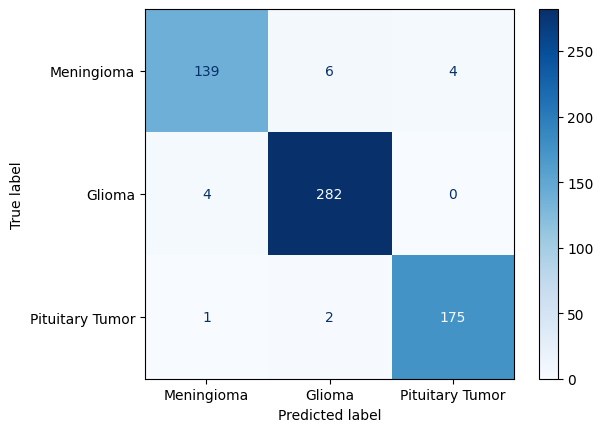

In [16]:
# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Meningioma', 'Glioma', 'Pituitary Tumor'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

In [ ]:
# Save Model
model_save_path = "/content/combined_vgg16_quantum_model.h5"
combined_model.save(model_save_path)
print(f"Model saved to {model_save_path}")
